# AutoML for Images

### Birds image classification with Azure ML and AutoML for Images (Image Classification Task)

We will build a computer vision model to detect birds

<img src="https://github.com/retkowsky/AutoMLforImages/blob/main/images/birdssnapshot.jpg?raw=true">

Full images are available here: https://www.kaggle.com/gpiosenka/100-bird-species

## Setup
> To use this notebook, **you will need to install the private preview package for AutoML for Images from the private index**.

In [1]:
#!pip install --upgrade "azureml-train-core<0.1.1" "azureml-train-automl<0.1.1" "azureml-contrib-dataset<0.1.1" --extra-index-url "https://azuremlsdktestpypi.azureedge.net/automl_for_images_private_preview/"

In [2]:
#!pip install seaborn

## 1. Informations

In [3]:
import numpy as np
import json
import os
import urllib
from zipfile import ZipFile
import seaborn as sns
import pandas as pd

In [4]:
import sys
print("Python version =", sys.version)

Python version = 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [5]:
import datetime
now = datetime.datetime.now()
print("Today =", now)

Today = 2021-05-29 17:44:14.910036


In [6]:
import azureml.core
print("You are using Azure ML version", azureml.core.VERSION)

You are using Azure ML version 0.1.0.36994775


In [7]:
# Your local platform
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['Platform']=platform.system()
        info['Platform-release']=platform.release()
        info['Platform-version']=platform.version()
        info['Architecture']=platform.machine()
        info['Hostname']=socket.gethostname()
        info['IP-address']=socket.gethostbyname(socket.gethostname())
        info['MAC-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['Processor']=platform.processor()
        info['RAM']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" Go"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'Platform': 'Linux',
 'Platform-release': '5.4.0-1046-azure',
 'Platform-version': '#48~18.04.1-Ubuntu SMP Tue Apr 13 19:41:38 UTC 2021',
 'Architecture': 'x86_64',
 'Hostname': 'standardd15v2',
 'IP-address': '127.0.0.1',
 'MAC-address': 'cf:98:8b:06:31:30',
 'Processor': 'x86_64',
 'RAM': '138 Go'}

## 2. Workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

> Create an Azure ML Workspace within your Azure subscription, or load an existing workspace.

In [8]:
subscription_id='tobereplaced'   
resource_group='automlvision-rg'   
workspace_name='automlvision'

In [9]:
from azureml.core import Workspace
try:
   ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
   ws.write_config()
   print("OK")
except:
   print("Error: Workspace not found")

OK


In [10]:
from azureml.core import Workspace
ws = Workspace.from_config()

In [11]:
ws.name, ws.resource_group

('automlvision', 'automlvision-rg')

## 3. Azure ML GPU Compute target setup
**You will need to provide a [Compute Target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) that will be used for your AutoML model training.** <br><br>
**AutoML models for image tasks require GPU SKUs and support NC and ND families.** We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [12]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "gpu-birds"

try:
    compute_target = ws.compute_targets[cluster_name]
    print('Found existing compute target.')
except KeyError:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6', #GPU cluster
                                                           idle_seconds_before_scaledown=1800, #Time out
                                                           min_nodes=0, 
                                                           max_nodes=4)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Creating a new compute target...
Creating.........
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [13]:
# Compute status
compute_target.provisioning_state

'Succeeded'

In [14]:
# Compute cluster information
compute_target.get_status().serialize()

{'currentNodeCount': 0,
 'targetNodeCount': 0,
 'nodeStateCounts': {'preparingNodeCount': 0,
  'runningNodeCount': 0,
  'idleNodeCount': 0,
  'unusableNodeCount': 0,
  'leavingNodeCount': 0,
  'preemptedNodeCount': 0},
 'allocationState': 'Steady',
 'allocationStateTransitionTime': '2021-05-29T17:44:58.776000+00:00',
 'errors': None,
 'creationTime': '2021-05-29T17:44:25.506369+00:00',
 'modifiedTime': '2021-05-29T17:45:11.186463+00:00',
 'provisioningState': 'Succeeded',
 'provisioningStateTransitionTime': None,
 'scaleSettings': {'minNodeCount': 0,
  'maxNodeCount': 4,
  'nodeIdleTimeBeforeScaleDown': 'PT1800S'},
 'vmPriority': 'Dedicated',
 'vmSize': 'STANDARD_NC6'}

In [15]:
# Compute VM size
compute_target.vm_size

'STANDARD_NC6'

## 4. Experiment Setup
Create an [Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) in your workspace to track your model training runs

In [16]:
from azureml.core import Experiment

experiment_name = 'AutomlImages-Birds' #Name of your experimentation
experiment = Experiment(ws, name=experiment_name)

In [17]:
experiment

Experiment(Name: AutomlImages-Birds,
Workspace: automlvision)

## 5. Dataset with input Training Data
In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an AzureML Labeled Dataset. You can either use a Labeled Dataset that you have exported from a Data Labeling project, or create a new Labeled Dataset with your labeled training data

### List of images files

In [18]:
%cd birdsimages

/mnt/batch/tasks/shared/LS_root/mounts/clusters/standardd15v2/code/Users/seretkow/AutoML Birds/birdsimages


In [29]:
print(os.listdir('.'))

['AFRICAN CROWNED CRANE', 'AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'ANHINGA', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ARARIPE MANAKIN', 'ASIAN CRESTED IBIS', 'BALD EAGLE', 'BALI STARLING', 'BALTIMORE ORIOLE', 'BANANAQUIT', 'BANDED BROADBILL', 'BAR-TAILED GODWIT', 'BARN OWL', 'BARN SWALLOW', 'BARRED PUFFBIRD', 'BAY-BREASTED WARBLER', 'BEARDED BARBET', 'BEARDED REEDLING', 'BELTED KINGFISHER', 'BIRD OF PARADISE', 'BLACK & YELLOW bROADBILL', 'BLACK FRANCOLIN', 'BLACK SKIMMER', 'BLACK SWAN', 'BLACK TAIL CRAKE', 'BLACK THROATED BUSHTIT', 'BLACK THROATED WARBLER', 'BLACK VULTURE', 'BLACK-CAPPED CHICKADEE', 'BLACK-NECKED GREBE', 'BLACK-THROATED SPARROW', 'BLACKBURNIAM WARBLER', 'BLUE GROUSE', 'BLUE HERON', 'BOBOLINK', 'BORNEAN BRISTLEHEAD', 'BORNEAN LEAFBIRD', 'BROWN NOODY', 'BROWN THRASHER', 'BULWERS PHEASANT', 'CACTUS WREN', 'CANARY', 'CAPE MAY WARBLER', 'CAPUCHINBIRD', 'CARMINE BEE-EATER', 'CASPIAN TERN', 'CASSOWARY', 'CEDA

In [30]:
for root, _, files in os.walk('.'):
    print("Dir:", root, "with", len(files), "images files.")

Dir: . with 0 images files.
Dir: ./AFRICAN CROWNED CRANE with 137 images files.
Dir: ./AFRICAN FIREFINCH with 140 images files.
Dir: ./ALBATROSS with 132 images files.
Dir: ./ALEXANDRINE PARAKEET with 165 images files.
Dir: ./AMERICAN AVOCET with 179 images files.
Dir: ./AMERICAN PIPIT with 179 images files.
Dir: ./AMERICAN REDSTART with 139 images files.
Dir: ./ANHINGA with 147 images files.
Dir: ./ANNAS HUMMINGBIRD with 139 images files.
Dir: ./ANTBIRD with 150 images files.
Dir: ./ARARIPE MANAKIN with 155 images files.
Dir: ./ASIAN CRESTED IBIS with 157 images files.
Dir: ./BALD EAGLE with 160 images files.
Dir: ./BALI STARLING with 132 images files.
Dir: ./BALTIMORE ORIOLE with 137 images files.
Dir: ./BANANAQUIT with 166 images files.
Dir: ./BANDED BROADBILL with 194 images files.
Dir: ./BAR-TAILED GODWIT with 114 images files.
Dir: ./BARN OWL with 119 images files.
Dir: ./BARN SWALLOW with 132 images files.
Dir: ./BARRED PUFFBIRD with 136 images files.
Dir: ./BAY-BREASTED WARBLER

### Some samples:

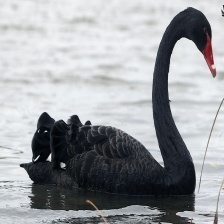

In [31]:
from IPython.display import Image
sample_image = 'BLACK SWAN/001.jpg'
Image(filename=sample_image) 

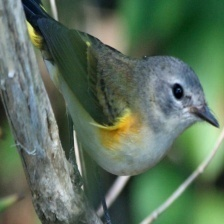

In [32]:
from IPython.display import Image
sample_image = 'AMERICAN REDSTART/001.jpg'
Image(filename=sample_image) 

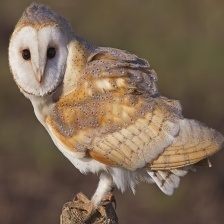

In [33]:
from IPython.display import Image
sample_image = 'BARN OWL/001.jpg'
Image(filename=sample_image) 

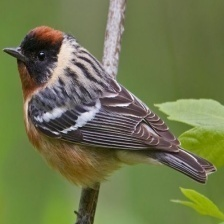

In [34]:
from IPython.display import Image
sample_image = 'BAY-BREASTED WARBLER/001.jpg'
Image(filename=sample_image) 

### Convert the downloaded data to JSONL


In [35]:
%cd ..

/mnt/batch/tasks/shared/LS_root/mounts/clusters/standardd15v2/code/Users/seretkow/AutoML Birds


In [36]:
src = "birdsimages/"

train_validation_ratio = 5

# Retrieving default datastore that got automatically created when we setup a workspace
workspaceblobstore = ws.get_default_datastore().name

# Path to the training and validation files
train_annotations_file = os.path.join(src, "train_annotations.jsonl")
validation_annotations_file = os.path.join(src, "validation_annotations.jsonl")

# sample json line dictionary
json_line_sample = \
    {
        "image_url": "AmlDatastore://" + workspaceblobstore + "/"
                     + os.path.basename(os.path.dirname(src)),
        "label": "",
        "label_confidence": 1.0
    }

index = 0
# Scan each sub directary and generate jsonl line
with open(train_annotations_file, 'w') as train_f:
    with open(validation_annotations_file, 'w') as validation_f:
        for className in os.listdir(src):
            subDir = src + className
            if not os.path.isdir(subDir):
                continue
            # Scan each sub directary
            print("Parsing " + subDir)
            for image in os.listdir(subDir):
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"/{className}/{image}"
                json_line["label"] = className

                if index % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")
                index += 1

Parsing birdsimages/AFRICAN CROWNED CRANE
Parsing birdsimages/AFRICAN FIREFINCH
Parsing birdsimages/ALBATROSS
Parsing birdsimages/ALEXANDRINE PARAKEET
Parsing birdsimages/AMERICAN AVOCET
Parsing birdsimages/AMERICAN PIPIT
Parsing birdsimages/AMERICAN REDSTART
Parsing birdsimages/ANHINGA
Parsing birdsimages/ANNAS HUMMINGBIRD
Parsing birdsimages/ANTBIRD
Parsing birdsimages/ARARIPE MANAKIN
Parsing birdsimages/ASIAN CRESTED IBIS
Parsing birdsimages/BALD EAGLE
Parsing birdsimages/BALI STARLING
Parsing birdsimages/BALTIMORE ORIOLE
Parsing birdsimages/BANANAQUIT
Parsing birdsimages/BANDED BROADBILL
Parsing birdsimages/BAR-TAILED GODWIT
Parsing birdsimages/BARN OWL
Parsing birdsimages/BARN SWALLOW
Parsing birdsimages/BARRED PUFFBIRD
Parsing birdsimages/BAY-BREASTED WARBLER
Parsing birdsimages/BEARDED BARBET
Parsing birdsimages/BEARDED REEDLING
Parsing birdsimages/BELTED KINGFISHER
Parsing birdsimages/BIRD OF PARADISE
Parsing birdsimages/BLACK & YELLOW bROADBILL
Parsing birdsimages/BLACK FRANCO

### Upload the JSONL file and images to Datastore  
In order to use the data for training in Azure ML, we upload it to our Azure ML Workspace via a [Datastore](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores). The datastore provides a mechanism for you to upload/download data, and interact with it from your remote compute targets. It is an abstraction over Azure Storage.



In [37]:
# Retrieving default datastore that got automatically created when we setup a workspace
ds = ws.get_default_datastore()
ds.upload(src_dir='./birdsimages/', target_path='birdsimages')

Uploading an estimated of 31890 files
Uploading ./birdsimages/train_annotations.jsonl
Uploaded ./birdsimages/train_annotations.jsonl, 1 files out of an estimated total of 31890
Uploading ./birdsimages/validation_annotations.jsonl
Uploaded ./birdsimages/validation_annotations.jsonl, 2 files out of an estimated total of 31890
Uploading ./birdsimages/AFRICAN CROWNED CRANE/001.jpg
Uploaded ./birdsimages/AFRICAN CROWNED CRANE/001.jpg, 3 files out of an estimated total of 31890
Uploading ./birdsimages/AFRICAN CROWNED CRANE/002.jpg
Uploaded ./birdsimages/AFRICAN CROWNED CRANE/002.jpg, 4 files out of an estimated total of 31890
Uploading ./birdsimages/AFRICAN CROWNED CRANE/003.jpg
Uploaded ./birdsimages/AFRICAN CROWNED CRANE/003.jpg, 5 files out of an estimated total of 31890
Uploading ./birdsimages/AFRICAN CROWNED CRANE/004.jpg
Uploaded ./birdsimages/AFRICAN CROWNED CRANE/004.jpg, 6 files out of an estimated total of 31890
Uploading ./birdsimages/AFRICAN CROWNED CRANE/005.jpg
Uploaded ./birds

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Uploaded ./birdsimages/RUBY THROATED HUMMINGBIRD/110.jpg, 26810 files out of an estimated total of 31890
Uploading ./birdsimages/RUBY THROATED HUMMINGBIRD/111.jpg
Uploaded ./birdsimages/RUBY THROATED HUMMINGBIRD/111.jpg, 26811 files out of an estimated total of 31890
Uploading ./birdsimages/RUBY THROATED HUMMINGBIRD/112.jpg
Uploaded ./birdsimages/RUBY THROATED HUMMINGBIRD/112.jpg, 26812 files out of an estimated total of 31890
Uploading ./birdsimages/RUBY THROATED HUMMINGBIRD/113.jpg
Uploaded ./birdsimages/RUBY THROATED HUMMINGBIRD/113.jpg, 26813 files out of an estimated total of 31890
Uploading ./birdsimages/RUBY THROATED HUMMINGBIRD/114.jpg
Uploaded ./birdsimages/RUBY THROATED HUMMINGBIRD/114.jpg, 26814 files out of an estimated total of 31890
Uploading ./birdsimages/RUBY THROATED HUMMINGBIRD/115.jpg
Uploaded ./birdsimages/RUBY THROATED HUMMINGBIRD/115.jpg, 26815 files out of an estimated total of 31890
Uploading ./birdsimages/RUBY THROATED HUMMINGBIRD/116.jpg
Uploaded ./birdsimages

$AZUREML_DATAREFERENCE_99f9106a49e54211b7dc3289df4db171

Finally, we need to create an Azure ML [Dataset](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores) from the data we uploaded to the Datastore. We create one dataset for training and one for validation.

In [38]:
from azureml.contrib.dataset.labeled_dataset import _LabeledDatasetFactory, LabeledDatasetTask
from azureml.core import Dataset

training_dataset_name = 'BirdsTrainingDataset'
if training_dataset_name in ws.datasets:
    training_dataset = ws.datasets.get(training_dataset_name)
    print('Found the training dataset', training_dataset_name)
else:
    # create training dataset
    training_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.IMAGE_CLASSIFICATION, path=ds.path('birdsimages/train_annotations.jsonl'))
    training_dataset = training_dataset.register(workspace=ws, name=training_dataset_name)
    
# create validation dataset
validation_dataset_name = "BirdsValidationDataset"
if validation_dataset_name in ws.datasets:
    validation_dataset = ws.datasets.get(validation_dataset_name)
    print('Found the validation dataset', validation_dataset_name)
else:
    validation_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.IMAGE_CLASSIFICATION, path=ds.path('birdsimages/validation_annotations.jsonl'))
    validation_dataset = validation_dataset.register(workspace=ws, name=validation_dataset_name)

print()
print("Training dataset name:" + training_dataset.name)
print("Validation dataset name:" + validation_dataset.name)


Training dataset name:BirdsTrainingDataset
Validation dataset name:BirdsValidationDataset


Validation dataset is optional. If no validation dataset is specified, by default 20% of your training data will be used for validation. You can control the percentage using the `split_ratio` argument - please refer to the documentation for more details.

This is what the training dataset looks like

In [39]:
df=training_dataset.to_pandas_dataframe()

In [41]:
df.shape

(25510, 3)

In [44]:
df.dtypes

image_url            object
label                object
label_confidence    float64
dtype: object

In [45]:
df.head()

image_url                  label  \
0  StreamInfo(AmlDatastore://birdsimages/AFRICAN ...  AFRICAN CROWNED CRANE   
1  StreamInfo(AmlDatastore://birdsimages/AFRICAN ...  AFRICAN CROWNED CRANE   
2  StreamInfo(AmlDatastore://birdsimages/AFRICAN ...  AFRICAN CROWNED CRANE   
3  StreamInfo(AmlDatastore://birdsimages/AFRICAN ...  AFRICAN CROWNED CRANE   
4  StreamInfo(AmlDatastore://birdsimages/AFRICAN ...  AFRICAN CROWNED CRANE   

   label_confidence  
0               1.0  
1               1.0  
2               1.0  
3               1.0  
4               1.0

In [49]:
# Counts images by labels
df['label'].value_counts()

HOUSE FINCH         199
WOOD DUCK           172
CASPIAN TERN        171
OYSTER CATCHER      165
DARK EYED JUNCO     163
                   ... 
CRESTED AUKLET       85
SCARLET MACAW        84
FRIGATE              84
BULWERS PHEASANT     83
RED HEADED DUCK      83
Name: label, Length: 226, dtype: int64

In [50]:
# Percentage values
df['label'].value_counts(normalize=True)

HOUSE FINCH         0.007801
WOOD DUCK           0.006742
CASPIAN TERN        0.006703
OYSTER CATCHER      0.006468
DARK EYED JUNCO     0.006390
                      ...   
CRESTED AUKLET      0.003332
SCARLET MACAW       0.003293
FRIGATE             0.003293
BULWERS PHEASANT    0.003254
RED HEADED DUCK     0.003254
Name: label, Length: 226, dtype: float64

## 6. Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML runs for image related tasks are specified using the 'AutoMLImageConfig' - please refer to the [documentation](https://github.com/swatig007/automlForImages#readme) for the details on the parameters that can be used and their values. 

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify a single model or choose to sweep over multiple ones.<br><br> **Currently supported model algorithms for image classification: 'resnet18', 'resnet34', 'resnet50', 'mobilenetv2', 'seresnext'.**

### Using default hyperparameter values for the specified algorithm

Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This is for employing a more iterative approach, because with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially and you need more iterations to find optimal configurations.

If you wish to use the default hyperparameter values for a given algorithm (say **resnet50**), you can specify the config for your AutoML Image runs as follows:

In [51]:
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import RandomParameterSampling
from azureml.train.hyperdrive import GridParameterSampling
from azureml.train.hyperdrive import choice

In [52]:
# AutoML Configuration
image_config_resnet50 = AutoMLImageConfig(task='image-classification', # AutoML Vision task
                                          compute_target=compute_target, # Compute target
                                          training_data=training_dataset, # Training dataset
                                          validation_data=validation_dataset, # Validation dataset
                                          hyperparameter_sampling=GridParameterSampling({'model_name': 
                                                                                        choice('resnet50')})) # CV Model

## 7. Submitting an AutoML run for Computer Vision tasks 
Once you've created the config settings for your run, **you can submit an AutoML run** using the config in order to train a vision model using your training dataset.

In [53]:
automl_image_run = experiment.submit(image_config_resnet50)

Submitting remote run.


In [54]:
automl_image_run.wait_for_completion(wait_post_processing=True) # Wait until automl run is finished

{'runId': 'AutoML_ae4dc14d-4c55-469a-8c4c-c932749bde6c',
 'target': 'gpu-birds',
 'status': 'Completed',
 'startTimeUtc': '2021-05-29T18:48:35.536636Z',
 'endTimeUtc': '2021-05-29T21:30:57.557347Z',
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'gpu-birds',
  'AMLSettingsJsonString': '{"path":null,"name":"AutomlImages-Birds","subscription_id":"70b8f39e-8863-49f7-b6ba-34a80799550c","resource_group":"automlvision-rg","workspace_name":"automlvision","region":"westeurope","compute_target":"gpu-birds","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1,"primary_metric":"accuracy","task_type":"image-classifica

In [55]:
automl_image_run.id

'AutoML_ae4dc14d-4c55-469a-8c4c-c932749bde6c'

In [56]:
experiment

Experiment(Name: AutomlImages-Birds,
Workspace: automlvision)

In [57]:
# List of all the AutoML for Images metrics values
automlvisionmetrics = automl_image_run.get_metrics()
metricsdf=pd.DataFrame(automl_image_run.get_metrics())
metricsdf

recall  average_class_recall  average_class_f2_score     iou  \
0   56.689                56.689                  54.373  58.200   
1   69.449                69.449                  69.318  70.006   
2   84.815                84.815                  84.600  85.278   
3   89.599                89.599                  89.566  89.981   
4   91.706                91.706                  91.597  91.910   
5   92.575                92.575                  92.519  92.756   
6   92.875                92.875                  92.821  93.007   
7   93.991                93.991                  93.973  94.199   
8   94.601                94.601                  94.580  94.763   
9   94.945                94.945                  94.935  95.093   
10  94.996                94.996                  94.995  95.171   
11  95.837                95.837                  95.804  95.939   
12  96.266                96.266                  96.246  96.347   
13  96.730                96.730                  96.722  96.817   
14  96.444                96.444                  96.441  96.535   

    average_class_precision  average_sample_f1_score  average_sample_f2_score  \
0                    67.383                   58.200                   58.200   
1                    83.528                   70.006                   70.006   
2                    89.235                   85.278                   85.278   
3                    91.715                   89.981                   89.981   
4                    93.000                   91.910                   91.910   
5                    93.440                   92.756                   92.756   
6                    93.771                   93.007                   93.007   
7                    94.747                   94.199                   94.199   
8                    95.174                   94.763                   94.763   
9                    95.394                   95.093                   95.093   
10                   95.575                   95.171                   95.171   
11                   96.085                   95.939                   95.939   
12                   96.516                   96.347                   96.347   
13                   96.909                   96.817                   96.817   
14                   96.638                   96.535                   96.535   

    accuracy  precision  average_class_f1_score  
0     58.200     67.383                  54.182  
1     70.006     83.528                  71.707  
2     85.278     89.235                  85.234  
3     89.981     91.715                  89.946  
4     91.910     93.000                  91.756  
5     92.756     93.440                  92.655  
6     93.007     93.771                  92.952  
7     94.199     94.747                  94.097  
8     94.763     95.174                  94.673  
9     95.093     95.394                  95.011  
10    95.171     95.575                  95.102  
11    95.939     96.085                  95.830  
12    96.347     96.516                  96.278  
13    96.817     96.909                  96.751  
14    96.535     96.638                  96.475

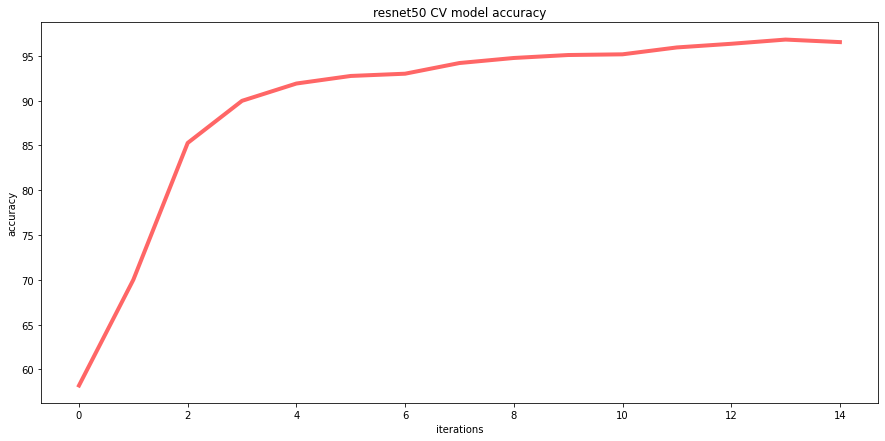

In [58]:
# Let's plot the accuracy metric for the CV model, save the graph to a jpg file and log it to the Azure ML experiment
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))
plt.plot(automlvisionmetrics['accuracy'], 'r-', lw=4, alpha=.6)
plt.xlabel('iterations', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('resnet50 CV model accuracy', fontsize=12)
plt.savefig('accuracy_resnet50.jpg', dpi=150) # Saving image in a jpg file
automl_image_run.log_image(name='accuracy_resnet50.jpg', plot=plt) # Logging the graph into the Azure ML experiment
plt.show()

In [59]:
# Checking the output graph
!ls accuracy_resnet50.jpg -l

-rwxrwxrwx 1 root root 92856 May 29 21:31 accuracy_resnet50.jpg


In [60]:
# You can view the jpg file in the experiment
experiment

Experiment(Name: AutomlImages-Birds,
Workspace: automlvision)

## 8. Register the optimal CV model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [61]:
from azureml.core import Run
hyperdrive_run = Run(experiment=experiment, run_id=automl_image_run.id + '_HD')
hyperdrive_run

Run(Experiment: AutomlImages-Birds,
Id: AutoML_ae4dc14d-4c55-469a-8c4c-c932749bde6c_HD,
Type: hyperdrive,
Status: Completed)

In [62]:
# Defining tags for the custom vision model
cvmodel_tags={"Data": "Images", 
              "Context" : "Birds Detection",
              "Task" : "Best AutoML Images",
              "Framework" : "AzureML AutoML for Images",
              "AutoML Metric" : "Accuracy"}

In [63]:
# Register the best model from the AutoML Vision run
best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties['model_name']

model = best_child_run.register_model(model_name = model_name,
                                      model_path='outputs/model.pt',
                                      description='Birds Detection Classification CV model',
                                      tags=cvmodel_tags)

In [64]:
# We can download the CV model
model.download(target_dir='.', exist_ok=True)

'model.pt'

In [65]:
# Checking the downloaded .pt model file
!ls model.pt -l

-rwxrwxrwx 1 root root 192144856 May 29 21:31 model.pt


### Model informations from the Azure ML model repository

In [66]:
model

Model(workspace=Workspace.create(name='automlvision', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='automlvision-rg'), name=AutoMLae4dc14d40, id=AutoMLae4dc14d40:1, version=1, tags={'Data': 'Images', 'Context': 'Birds Detection', 'Task': 'Best AutoML Images', 'Framework': 'AzureML AutoML for Images', 'AutoML Metric': 'Accuracy'}, properties={})

In [67]:
model.id

'AutoMLae4dc14d40:1'

In [68]:
model.name

'AutoMLae4dc14d40'

In [69]:
model.version

1

In [70]:
model.tags

{'Data': 'Images',
 'Context': 'Birds Detection',
 'Task': 'Best AutoML Images',
 'Framework': 'AzureML AutoML for Images',
 'AutoML Metric': 'Accuracy'}

In [71]:
model.created_time

datetime.datetime(2021, 5, 29, 21, 31, 6, 614864, tzinfo=<isodate.tzinfo.Utc object at 0x7fef77a47908>)

## 9. Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. **You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)).**<br><br> ACI is the perfect option for testing deployments, while AKS is better suited for for high-scale, production usage. <br><br>
**In this tutorial, we will deploy the model as a web service in AKS.**
You will need to first create an AKS compute cluster, or use an existing AKS cluster. <br>
You can use either GPU or CPU VM SKUs for your deployment cluster

In [72]:
%%time
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your cluster
aks_name = "cluster-aks-gpu"

# Check to see if the cluster already exists
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    # Provision AKS cluster with GPU machine
    prov_config = AksCompute.provisioning_configuration(vm_size="STANDARD_NC6", 
                                                        location="eastus2")
    # Create the cluster
    aks_target = ComputeTarget.create(workspace=ws, 
                                      name=aks_name, 
                                      provisioning_configuration=prov_config)
    aks_target.wait_for_completion(show_output=True)

Found existing compute target.
CPU times: user 17.7 ms, sys: 0 ns, total: 17.7 ms
Wall time: 316 ms


Next, you will need to define the inference configuration, that describes how to set up the web-service containing your model. You can use the scoring script and the environment from the training run in your inference config.  
You can then deploy the model as an AKS web service.

In [73]:
# Settings

from azureml.core.model import InferenceConfig
from azureml.core.webservice import AksWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

best_child_run.download_file('outputs/scoring_file_v_1_0_0.py', output_file_path='score.py')
environment = best_child_run.get_environment()
inference_config = InferenceConfig(entry_script='score.py', environment=environment)

endpoint_name='automlbirds' #Name of the deployed model

aks_tags={"Data": "Images", 
          "Topic" : "Birds Detection Custom Vision model", 
          "Task" : "Image Classification",
          "Framework" : "AutoML Images best model", 
          "AKS" : "True"}

aks_description="Computer vision model to identify birds"

aks_config = AksWebservice.deploy_configuration(autoscale_enabled=True,                                                    
                                                cpu_cores=1,
                                                memory_gb=50,
                                                enable_app_insights=True,
                                                description=aks_description,
                                                tags=aks_tags)

In [74]:
# Checking the file we downloaded
!ls score.py -l

-rwxrwxrwx 1 root root 1921 May 29 21:31 score.py


In [75]:
# Viewing the score.py file
with open(os.path.join('score.py'), 'r') as f:
    print(f.read())

# ---------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# ---------------------------------------------------------
import os
import tempfile
import logging

from azureml.contrib.services.aml_request import rawhttp
from azureml.automl.core.shared import logging_utilities
from azureml.contrib.services.aml_response import AMLResponse

from azureml.contrib.automl.dnn.vision.common.utils import _set_logging_parameters
from azureml.contrib.automl.dnn.vision.common.model_export_utils import load_model, run_inference
from azureml.contrib.automl.dnn.vision.common.logging_utils import get_logger

from azureml.contrib.automl.dnn.vision.classification.inference.score import _score_with_model

TASK_TYPE = 'image-classification'
logger = get_logger('azureml.automl.core.scoring_script_images')


def init():
    global model
    
    # Set up logging
    _set_logging_parameters(TASK_TYPE, {})

    model_path = os.path.join(os.getenv('AZU

### Let's deploy the CV model into AKS

In [76]:
%%time
aks_service = Model.deploy(ws,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target,
                           name=endpoint_name,
                           overwrite=True)

aks_service.wait_for_deployment(show_output=True)

print("\nDone. Model is deployed. Ready to use!")
print("\nAKS service status=", aks_service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-05-29 21:31:22+00:00 Creating Container Registry if not exists.
2021-05-29 21:31:22+00:00 Registering the environment.
2021-05-29 21:31:23+00:00 Use the existing image..
2021-05-29 21:31:26+00:00 Creating resources in AKS.
2021-05-29 21:31:29+00:00 Submitting deployment to compute.
2021-05-29 21:31:29+00:00 Checking the status of deployment automlbirds..
2021-05-29 21:32:13+00:00 Checking the status of inference endpoint automlbirds.
Succeeded
AKS service creation operation finished, operation "Succeeded"

Done. Model is deployed. Ready to use!

AKS service status= Healthy
CPU times: user 284 ms, sys: 70.6 ms, total: 354 ms
Wall time: 1min 9s


> Usually it takes 2 or 3 minutes to deploy. You can see the endpoint in Azure ML Studio

In [77]:
print("Computer Vision model endpoint:", aks_service.scoring_uri)

Computer Vision model endpoint: http://20.94.33.29:80/api/v1/service/automlbirds/score


In [78]:
print("Computer Vision model endpoint properties:", aks_service.properties)

Computer Vision model endpoint properties: {'hasInferenceSchema': 'False', 'hasHttps': 'False'}


In [79]:
print("Computer Vision model endpoint tags:", aks_service.tags)

Computer Vision model endpoint tags: {'Data': 'Images', 'Topic': 'Birds Detection Custom Vision model', 'Task': 'Image Classification', 'Framework': 'AutoML Images best model', 'AKS': 'True'}


In [80]:
# You can have access to the logs
#print(aks_service.get_logs())

## 10. Test our deployed CV model
Finally, let's test our deployed Computer Vision model to predict new images. You can pass in any image.

In [81]:
print("Our Computer Vision model endpoint:", aks_service.scoring_uri)
print("\nStatus=", aks_service.state)

Our Computer Vision model endpoint: http://20.94.33.29:80/api/v1/service/automlbirds/score

Status= Healthy


### Test 1

Let's download an image file to test:

In [251]:
image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/Bird1.jpg?raw=true'
image_file = 'test1.jpg'
urllib.request.urlretrieve(image_url, filename=image_file)
print("Image is downloaded and ready to be predicted.")

Image is downloaded and ready to be predicted.


In [252]:
import cv2 as cv
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

Image informations:
- Image filename: test1.jpg
- Image shape: (426, 640, 3)
- Image size: 817920


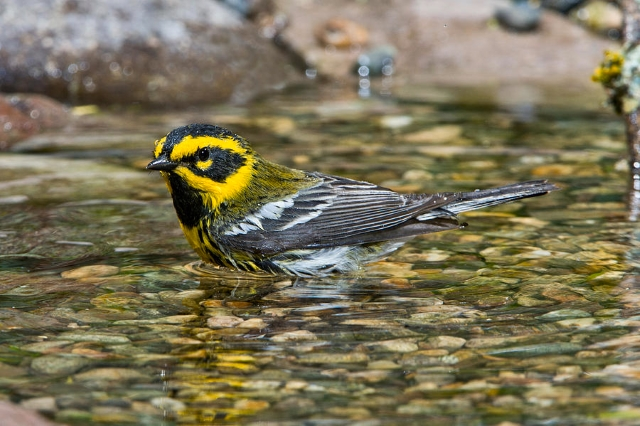

In [253]:
from IPython.display import Image
Image(filename=image_file)

In [254]:
import requests

# URL for the web service
scoring_uri = aks_service.scoring_uri
# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()
# Load image data
data = open(image_file, 'rb').read()
# Set the content type
headers = {'Content-Type': 'application/octet-stream'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print("Status code=",resp.status_code)
print("\nElapsed=", resp.elapsed)
print("\nResults=", resp.text)

Status code= 200

Elapsed= 0:00:00.576836

Results= {"filename": "/tmp/tmpi6hoig8w", "probs": [5.450311135746233e-08, 3.890840005738028e-08, 1.1545836997584047e-07, 8.44915692965742e-09, 6.602198823202343e-07, 1.3883467886444123e-07, 6.091099749028217e-07, 5.314403210832097e-07, 1.7955401290237205e-06, 6.582551463907294e-07, 1.9676226870046776e-08, 4.048157009606257e-08, 2.039811448639739e-07, 8.379780069844855e-08, 2.5403278414160013e-07, 2.8702608290132048e-08, 2.5302162498519465e-07, 7.361088449897579e-08, 1.2765045198648295e-07, 5.716040263337163e-08, 1.0342286032027914e-06, 3.5585856039688224e-06, 5.056476837239643e-08, 1.8687843805764714e-07, 3.69186956561407e-08, 1.093502177695882e-08, 3.3239282970498607e-07, 1.4808502157848125e-07, 5.076044828911108e-08, 2.2751292760858632e-07, 1.9459905686858292e-08, 6.164739829728205e-07, 3.0447715744230663e-06, 1.252996550960006e-08, 1.477009732298029e-07, 2.3719456976323272e-07, 5.237003506408655e-07, 0.00015519052976742387, 7.9045448728720

In [255]:
prediction=pd.DataFrame(resp.json()) #Convert the Json into a pandas dataframe
pred=prediction.sort_values(by='probs', ascending=False)
pred.head(5)

filename     probs                  labels
216  /tmp/tmpi6hoig8w  0.951989       TOWNSENDS WARBLER
100  /tmp/tmpi6hoig8w  0.047027  GOLDEN CHEEKED WARBLER
99   /tmp/tmpi6hoig8w  0.000386       GOLD WING WARBLER
37   /tmp/tmpi6hoig8w  0.000155    BLACKBURNIAM WARBLER
60   /tmp/tmpi6hoig8w  0.000126        COMMON FIRECREST

In [256]:
prediction = json.loads(resp.text)
label_index = np.argmax(prediction['probs']) # to take the max probability
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

print("Image file =", image_file)
print("Model prediction =", label, "\nwith Probability =", conf_score)
print()
print("\033[1;31;34mThis image shows a\033[1;31;31m", label,"\033[1;31;34mbird with a probability =", 
      round((conf_score*100), 2), "%")

Image file = test1.jpg
Model prediction = TOWNSENDS WARBLER 
with Probability = 0.9519887566566467

This image shows a TOWNSENDS WARBLER bird with a probability = 95.2 %


## Visualize predictions
Now that we have scored a test image, we can visualize the prediction for this image

TOWNSENDS WARBLER (0.952)


<Figure size 1296x864 with 0 Axes>

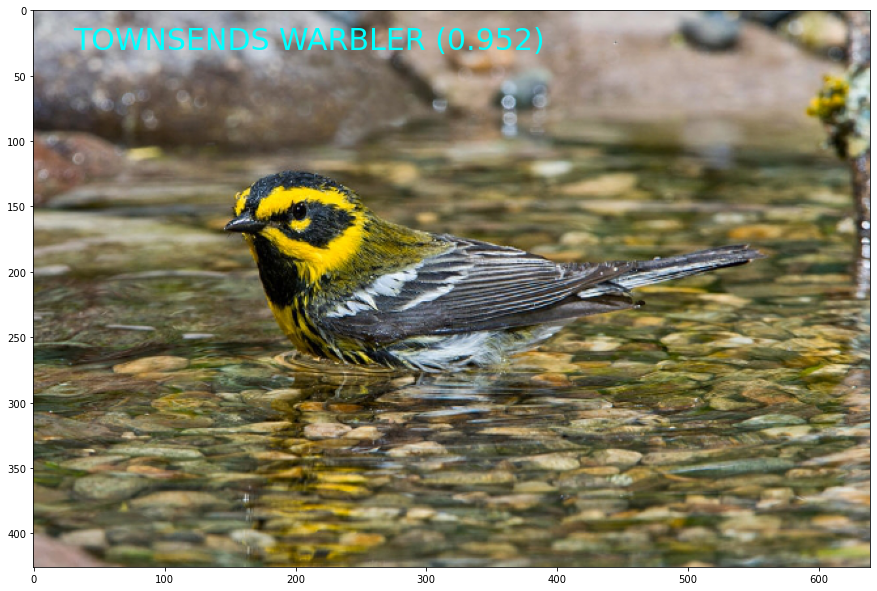

In [257]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15))
# Display the image
ax.imshow(img_np)

prediction = json.loads(resp.text)
label_index = np.argmax(prediction['probs'])
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

display_text = '{} ({})'.format(label, round(conf_score, 4))
print(display_text)

color = 'cyan' # Text color
plt.text(30, 30, display_text, color=color, fontsize=30)

fig.savefig('predictiontest1.jpg', dpi=150) #Saving image

plt.show()

### Test 2

In [258]:
image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/Bird2.jpg?raw=true'
image_file = 'test2.jpg'
urllib.request.urlretrieve(image_url, filename=image_file)
print("Image is downloaded and ready to be predicted.")

Image is downloaded and ready to be predicted.


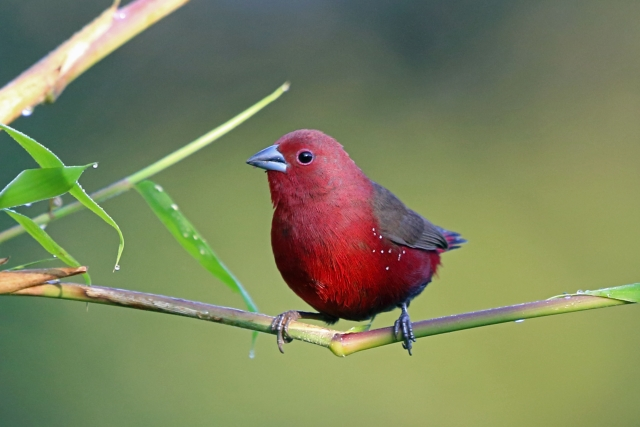

In [259]:
from IPython.display import Image
Image(filename=image_file)

In [260]:
import cv2 as cv
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

Image informations:
- Image filename: test2.jpg
- Image shape: (427, 640, 3)
- Image size: 819840


In [261]:
import requests

# URL for the web service
scoring_uri = aks_service.scoring_uri

# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()

# Load image data
data = open(image_file, 'rb').read()

# Set the content type
headers = {'Content-Type': 'application/octet-stream'}

# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'

# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print("Status code=",resp.status_code)
print("\nElapsed=", resp.elapsed)
print("\nResults=", resp.text)

Status code= 200

Elapsed= 0:00:00.772290

Results= {"filename": "/tmp/tmpmblkk53g", "probs": [6.797439944250527e-09, 0.9889879822731018, 9.301354353397073e-09, 4.971334988113085e-07, 1.8120931422060949e-09, 3.480919872345112e-07, 3.941606863122615e-08, 3.178947238779983e-08, 2.294628487220507e-08, 7.603395260957768e-06, 2.229112228135932e-09, 3.3487330686199357e-09, 9.098334863288926e-10, 1.0468728994794674e-08, 9.633384934204514e-08, 2.3493610967761924e-07, 4.682522103394149e-07, 3.1158129409902813e-09, 7.496090574932168e-07, 1.8161728121413034e-07, 5.084027066004637e-07, 4.240737183636156e-08, 2.397192417902261e-07, 2.2102263130818756e-07, 8.2408917023713e-08, 5.303627048647286e-08, 2.0717038751172367e-08, 3.7020291188127885e-07, 5.224975563322687e-09, 3.0051705568467924e-09, 1.312225435867731e-06, 5.918670353821653e-07, 1.2783533520632773e-06, 1.0494619395728932e-08, 7.674938018453759e-09, 1.618486855647916e-08, 2.5179989648904666e-08, 1.628734302983048e-08, 1.1614572636986509e-09,

In [262]:
prediction=pd.DataFrame(resp.json()) #Convert the Json into a pandas dataframe
pred=prediction.sort_values(by='probs', ascending=False)
pred.head(5)

filename     probs             labels
1    /tmp/tmpmblkk53g  0.988988  AFRICAN FIREFINCH
208  /tmp/tmpmblkk53g  0.010813   STRAWBERRY FINCH
185  /tmp/tmpmblkk53g  0.000041              ROBIN
165  /tmp/tmpmblkk53g  0.000019   PURPLE GALLINULE
154  /tmp/tmpmblkk53g  0.000015     PAINTED BUNTIG

In [263]:
prediction = json.loads(resp.text)
label_index = np.argmax(prediction['probs']) # to take the max probability
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

print("Image file =", image_file)
print("Model prediction =", label, "\nwith Probability =", conf_score)
print()
print("\033[1;31;34mThis image shows a\033[1;31;31m", label,"\033[1;31;34mbird with a probability =", 
      round((conf_score*100), 2), "%")

Image file = test2.jpg
Model prediction = AFRICAN FIREFINCH 
with Probability = 0.9889879822731018

This image shows a AFRICAN FIREFINCH bird with a probability = 98.9 %


This painting is a AFRICAN FIREFINCH (0.989)


<Figure size 1296x864 with 0 Axes>

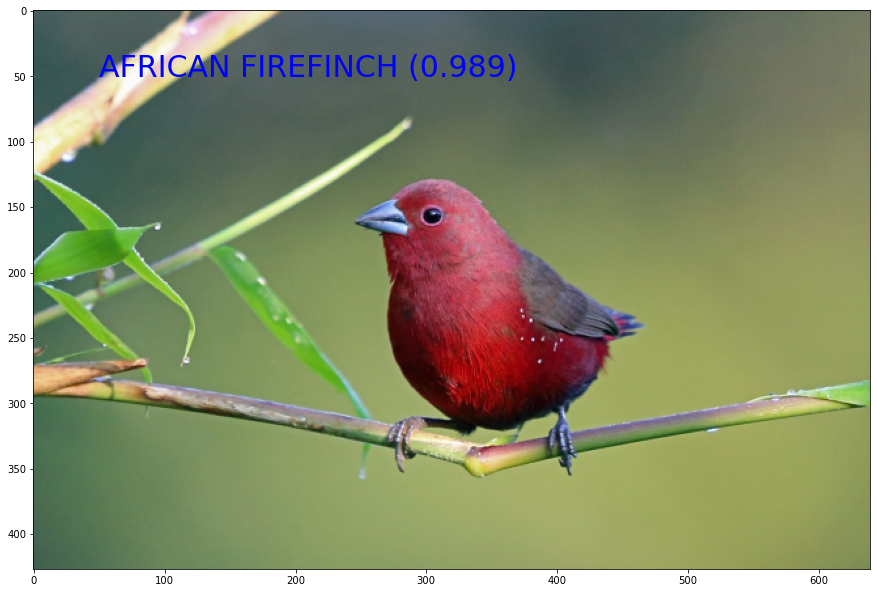

In [265]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15))
# Display the image
ax.imshow(img_np)

prediction = json.loads(resp.text)
label_index = np.argmax(prediction['probs'])
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

display_text = '{} ({})'.format(label, round(conf_score, 4))
print("This painting is a", display_text)

color = 'blue' #Text Color
plt.text(50, 50, display_text, color=color, fontsize=30)

fig.savefig('predictiontest2.jpg', dpi=150) #Saving image

plt.show()

### Test 3

In [266]:
image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/Bird3.jpg?raw=true'
image_file = 'test3.jpg'
urllib.request.urlretrieve(image_url, filename=image_file)
print("Image is downloaded and ready to be predicted.")

Image is downloaded and ready to be predicted.


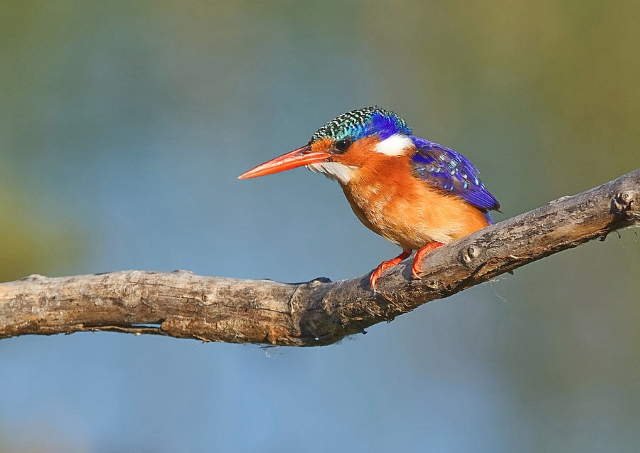

In [267]:
from IPython.display import Image
Image(filename=image_file)

In [268]:
import cv2 as cv
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

Image informations:
- Image filename: test3.jpg
- Image shape: (453, 640, 3)
- Image size: 869760


In [269]:
import requests

# URL for the web service
scoring_uri = aks_service.scoring_uri

# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()

# Load image data
data = open(image_file, 'rb').read()

# Set the content type
headers = {'Content-Type': 'application/octet-stream'}

# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'

# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print("Status code=",resp.status_code)
print("\nElapsed=", resp.elapsed)
print("\nResults=", resp.text)

Status code= 200

Elapsed= 0:00:00.491999

Results= {"filename": "/tmp/tmpcvtwkhuh", "probs": [2.3391666381655796e-09, 1.093647483685345e-08, 5.037625072645824e-08, 7.296652615451649e-09, 5.214745257831055e-08, 6.8279639720003615e-09, 4.353056226591434e-07, 1.3944372767582536e-06, 1.1460186044587317e-07, 5.32425644905743e-07, 6.032459509697219e-07, 2.5195930675181444e-07, 2.1070448497084726e-07, 2.568882351283719e-08, 1.2573361019008189e-08, 8.523515759861766e-08, 9.66892876874681e-09, 1.149959985013993e-07, 2.084129164359183e-06, 5.334447337190795e-07, 3.5512330214260146e-06, 4.224876022362878e-07, 4.942459952417266e-08, 4.5823699679203855e-07, 8.252207771874964e-05, 3.8577393723926434e-08, 7.892185038826938e-08, 1.8630959175425232e-07, 2.0734298686875263e-06, 1.4750132670826588e-08, 6.108736272381066e-08, 1.8309450751985423e-05, 9.48466762906719e-08, 2.9464769513154465e-10, 9.59079304863053e-09, 1.8772517762499774e-07, 7.826743142480552e-10, 1.8292071857217707e-08, 2.985502334240664e

In [270]:
prediction=pd.DataFrame(resp.json()) #Convert the Json into a pandas dataframe
pred=prediction.sort_values(by='probs', ascending=False)
pred.head(5)

filename     probs                   labels
130  /tmp/tmpcvtwkhuh  0.999574     MALACHITE KINGFISHER
191  /tmp/tmpcvtwkhuh  0.000140        RUFOUS KINGFISHER
24   /tmp/tmpcvtwkhuh  0.000083        BELTED KINGFISHER
207  /tmp/tmpcvtwkhuh  0.000046  STORK BILLED KINGFISHER
72   /tmp/tmpcvtwkhuh  0.000020               CUBAN TODY

In [271]:
prediction = json.loads(resp.text)
label_index = np.argmax(prediction['probs']) # to take the max probability
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

print("Image file =", image_file)
print("Model prediction =", label, "\nwith Probability =", conf_score)
print()
print("\033[1;31;34mThis image shows a\033[1;31;31m", label,"\033[1;31;34mbird with a probability =", 
      round((conf_score*100), 2), "%")

Image file = test3.jpg
Model prediction = MALACHITE KINGFISHER 
with Probability = 0.9995740056037903

This image shows a MALACHITE KINGFISHER bird with a probability = 99.96 %


This painting is a MALACHITE KINGFISHER (0.9996)


<Figure size 1296x864 with 0 Axes>

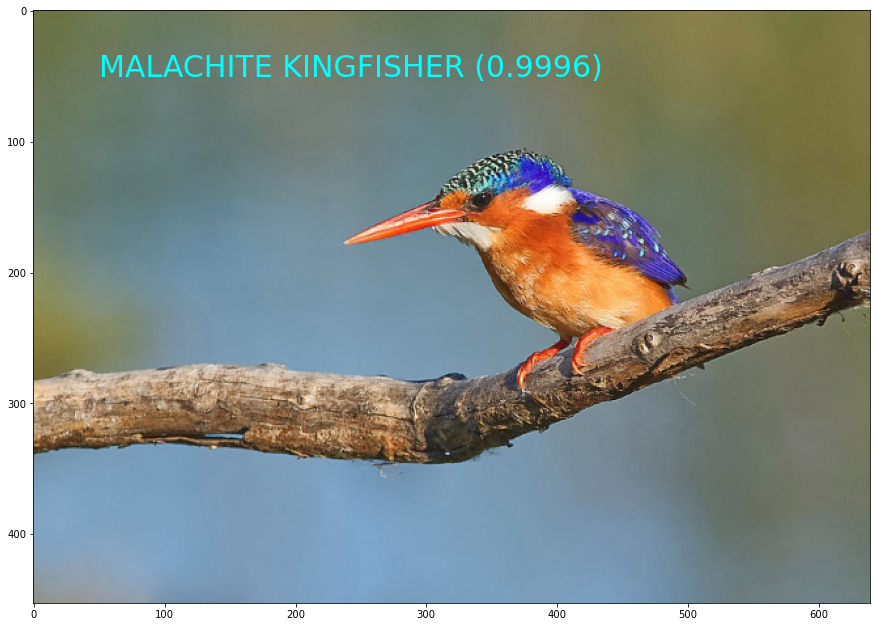

In [272]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15))
ax.imshow(img_np)

prediction = json.loads(resp.text)
label_index = np.argmax(prediction['probs'])
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

display_text = '{} ({})'.format(label, round(conf_score, 4))
print("This painting is a", display_text)

color = 'cyan' #Text Color

plt.text(50, 50, display_text, color=color, fontsize=30)
fig.savefig('predictiontest3.jpg', dpi=150) #Saving image

plt.show()

### Test 4

In [273]:
image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/Bird4.jpg?raw=true'
image_file = 'test4.jpg'
urllib.request.urlretrieve(image_url, filename=image_file)
print("Image is downloaded and ready to be predicted.")

Image is downloaded and ready to be predicted.


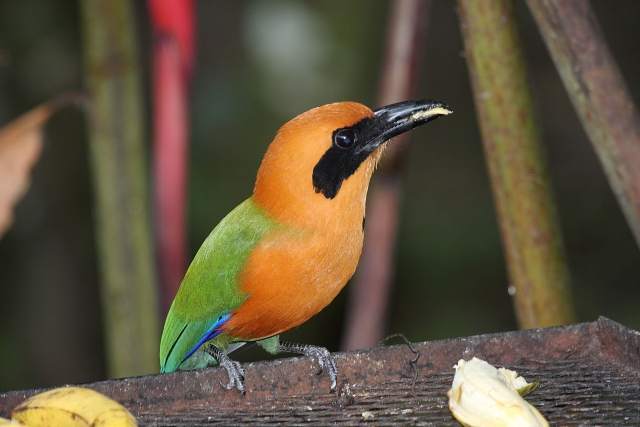

In [274]:
from IPython.display import Image
Image(filename=image_file)

In [275]:
import cv2 as cv
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

Image informations:
- Image filename: test4.jpg
- Image shape: (427, 640, 3)
- Image size: 819840


In [276]:

import requests

# URL for the web service
scoring_uri = aks_service.scoring_uri

# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()

# Load image data
data = open(image_file, 'rb').read()

# Set the content type
headers = {'Content-Type': 'application/octet-stream'}

# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'

# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print("Status code=",resp.status_code)
print("\nElapsed=", resp.elapsed)
print("\nResults=", resp.text)

Status code= 200

Elapsed= 0:00:00.499140

Results= {"filename": "/tmp/tmpmfjxa8af", "probs": [3.413088904835604e-07, 1.4367317817232106e-05, 3.357234845680068e-08, 4.485286524413823e-07, 8.17096363903147e-08, 4.51130723888582e-08, 2.7877894126504543e-07, 1.2227136494402657e-06, 4.2653152831917396e-07, 5.81914991926169e-06, 1.4707650734635536e-05, 8.70423519927499e-08, 3.7648831607839384e-08, 1.2598753528436646e-05, 6.606411261600442e-06, 5.026759936299641e-06, 3.6211333735991502e-06, 2.512578056723669e-08, 5.509696165972855e-08, 1.949127295119979e-07, 2.3549200989236851e-07, 4.60277504998885e-07, 8.49408024805598e-07, 5.4691199693479575e-06, 6.324010115577039e-08, 2.768211197690107e-05, 1.6223075363086537e-06, 1.5404476982894266e-07, 2.855640701682205e-08, 2.4207556847954947e-08, 5.93777997437428e-07, 1.6210068451982806e-06, 1.0250840887238155e-06, 3.637854817384323e-08, 2.6778019446282997e-07, 1.372663263055074e-07, 3.880343157902644e-08, 1.6029336791234527e-07, 3.3919079100996896e-0

In [277]:
prediction=pd.DataFrame(resp.json()) #Convert the Json into a pandas dataframe
pred=prediction.sort_values(by='probs', ascending=False)
pred.head(5)

filename     probs            labels
192  /tmp/tmpmfjxa8af  0.990697     RUFUOS MOTMOT
42   /tmp/tmpmfjxa8af  0.004915  BORNEAN LEAFBIRD
219  /tmp/tmpmfjxa8af  0.001023  TURQUOISE MOTMOT
215  /tmp/tmpmfjxa8af  0.000734           TOUCHAN
49   /tmp/tmpmfjxa8af  0.000365      CAPUCHINBIRD

In [278]:
prediction = json.loads(resp.text)
label_index = np.argmax(prediction['probs']) # to take the max probability
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

In [279]:
print("Image file =", image_file)
print("Model prediction =", label, "\nwith Probability =", conf_score)
print()
print("\033[1;31;34mThis image shows a\033[1;31;31m", label,"\033[1;31;34mbird with a probability =", 
      round((conf_score*100), 2), "%")

Image file = test4.jpg
Model prediction = RUFUOS MOTMOT 
with Probability = 0.9906967878341675

This image shows a RUFUOS MOTMOT bird with a probability = 99.07 %


This painting is a RUFUOS MOTMOT (0.9907)


<Figure size 1296x864 with 0 Axes>

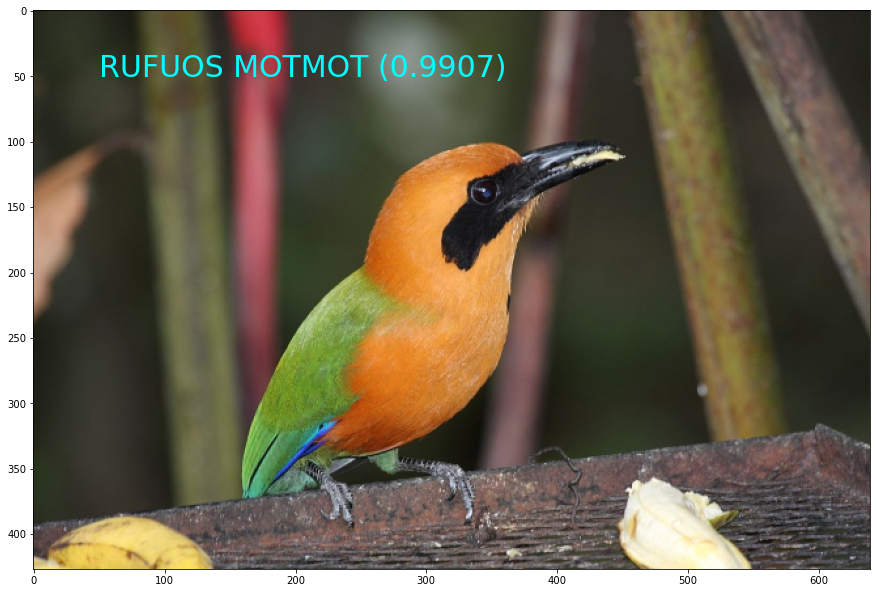

In [280]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15))
ax.imshow(img_np)

prediction = json.loads(resp.text)
label_index = np.argmax(prediction['probs'])
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

display_text = '{} ({})'.format(label, round(conf_score, 4))
print("This painting is a", display_text)

color = 'cyan' #Text Color

plt.text(50, 50, display_text, color=color, fontsize=30)
fig.savefig('predictiontest3.jpg', dpi=150) #Saving image

plt.show()

## 11. Clean up ressources

In [281]:
# Let's delete the model
model.delete
# Let's delete the service
aks_service.delete()
# Let's delete our Azure ML GPU compute cluster
compute_target.delete()

> End of notebook